In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import corpus_bleu
import json
import zipfile
import requests
from io import BytesIO
from collections import Counter
import pickle
from tqdm import tqdm
import random
import time
import shutil
import gc
from torch.nn.utils.rnn import pad_sequence
import math
from google.colab import drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create project directory in Google Drive
PROJECT_DIR = '/content/drive/MyDrive/image_captioning_project_transformer_new'
os.makedirs(PROJECT_DIR, exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/data', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/models', exist_ok=True)
os.makedirs(f'{PROJECT_DIR}/results', exist_ok=True)

In [ ]:
# Download COCO annotations if not already downloaded
def download_coco_annotations():
    annotations_url = 'http://images.cocodataset.org/annotations/annotations_trainval2017.zip'

    if not os.path.exists(f'{PROJECT_DIR}/data/annotations'):
        print("Downloading COCO annotations...")
        r = requests.get(annotations_url)
        z = zipfile.ZipFile(BytesIO(r.content))
        z.extractall(f'{PROJECT_DIR}/data')
        print("COCO annotations downloaded and extracted!")
    else:
        print("COCO annotations already exist.")

In [ ]:
# Download and extract COCO images, then select a subset
def download_coco_images(num_images=12000):
    # Create directories
    train_images_dir = f'{PROJECT_DIR}/data/train2017'
    os.makedirs(train_images_dir, exist_ok=True)
    temp_dir = f'{PROJECT_DIR}/data/temp'
    os.makedirs(temp_dir, exist_ok=True)

    # Check if we already have the selected image IDs
    selected_ids_path = f'{PROJECT_DIR}/data/selected_image_ids.pkl'
    if os.path.exists(selected_ids_path):
        print("Loading previously selected image IDs...")
        with open(selected_ids_path, 'rb') as f:
            return pickle.load(f)

    # Check if the train2017 directory already has images
    existing_images = os.listdir(train_images_dir) if os.path.exists(train_images_dir) else []
    if len(existing_images) > 0:
        print(f"Found {len(existing_images)} images already downloaded.")

        # Load captions file to get image IDs
        with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
            data = json.load(f)

        # Map filenames to image IDs
        filename_to_id = {img['file_name']: img['id'] for img in data['images']}
        selected_image_ids = set()

        # Get image IDs for existing files
        for filename in existing_images:
            if filename in filename_to_id:
                selected_image_ids.add(filename_to_id[filename])

        if len(selected_image_ids) >= num_images:
            print(f"Already have {len(selected_image_ids)} images, which is enough.")
            with open(selected_ids_path, 'wb') as f:
                pickle.dump(selected_image_ids, f)
            return selected_image_ids

    # Download the zip file if needed
    zip_path = f'{temp_dir}/train2017.zip'
    if not os.path.exists(zip_path):
        print("Downloading COCO train2017 images zip file...")
        train_url = 'http://images.cocodataset.org/zips/train2017.zip'

        # Stream download with progress tracking
        response = requests.get(train_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 1024  # 1MB

        with open(zip_path, 'wb') as f:
            for i, data in enumerate(response.iter_content(block_size)):
                f.write(data)
                downloaded = (i + 1) * block_size
                if i % 10 == 0:  # Update progress every 10MB
                    print(f"Downloaded {downloaded/1024/1024:.1f} MB / {total_size/1024/1024:.1f} MB ({100*downloaded/total_size:.1f}%)")

    # Load captions file to get image IDs
    with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
        data = json.load(f)

    # Get unique image IDs with captions
    all_image_ids = list(set(ann['image_id'] for ann in data['annotations']))

    # Select a subset of images
    selected_image_ids = set(random.sample(all_image_ids, min(num_images, len(all_image_ids))))

    # Create a mapping of image_id to file_name
    image_id_to_filename = {}
    for img in data['images']:
        if img['id'] in selected_image_ids:
            image_id_to_filename[img['id']] = img['file_name']

    # Extract only the selected images from the zip
    print(f"Extracting {len(selected_image_ids)} selected images from zip...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for img_id in tqdm(selected_image_ids):
            if img_id in image_id_to_filename:
                filename = image_id_to_filename[img_id]
                zip_path = f'train2017/{filename}'

                # Skip if already extracted
                if os.path.exists(f'{train_images_dir}/{filename}'):
                    continue

                try:
                    zip_ref.extract(zip_path, f'{PROJECT_DIR}/data')
                except Exception as e:
                    print(f"Error extracting {filename}: {e}")

    # Save selected image IDs for future reference
    with open(selected_ids_path, 'wb') as f:
        pickle.dump(selected_image_ids, f)

    print(f"Successfully selected and extracted {len(selected_image_ids)} images!")

    # Clean up the temporary zip file to save space
    if os.path.exists(temp_dir):
        print("Cleaning up temporary files...")
        shutil.rmtree(temp_dir)

    return selected_image_ids


In [ ]:
# Preprocess captions and build vocabulary
class Vocabulary:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __call__(self, word):
        if word not in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

In [ ]:
def build_vocab(captions, threshold=4):
    counter = Counter()
    for caption in captions:
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)

    # Filter words below threshold
    words = [word for word, count in counter.items() if count >= threshold]

    # Create vocabulary
    vocab = Vocabulary()
    vocab.add_word('<pad>')  # padding token
    vocab.add_word('<start>')  # start token
    vocab.add_word('<end>')  # end token
    vocab.add_word('<unk>')  # unknown token

    for word in words:
        vocab.add_word(word)

    return vocab

In [ ]:
def preprocess_captions(selected_image_ids):
    with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
        data = json.load(f)

    # Extract captions for selected images
    captions = []
    image_id_to_captions = {}

    for ann in data['annotations']:
        if ann['image_id'] in selected_image_ids:
            # Clean caption
            caption = ann['caption'].lower()
            caption = ' '.join(nltk.tokenize.word_tokenize(caption))

            captions.append(caption)

            if ann['image_id'] not in image_id_to_captions:
                image_id_to_captions[ann['image_id']] = []

            image_id_to_captions[ann['image_id']].append(caption)

    # Build vocabulary
    vocab = build_vocab(captions)

    # Save vocabulary and image_id_to_captions
    with open(f'{PROJECT_DIR}/data/vocab.pkl', 'wb') as f:
        pickle.dump(vocab, f)

    with open(f'{PROJECT_DIR}/data/image_id_to_captions.pkl', 'wb') as f:
        pickle.dump(image_id_to_captions, f)

    return vocab, image_id_to_captions


In [ ]:
# Create the dataset class
class COCODataset(Dataset):
    def __init__(self, image_dir, image_ids, image_id_to_captions, vocab, transform=None, max_length=50):
        self.image_dir = image_dir
        self.image_id_to_filename = {}
        self.data = []
        self.max_length = max_length

        # Load image_id to filename mapping
        with open(f'{PROJECT_DIR}/data/annotations/captions_train2017.json', 'r') as f:
            coco_data = json.load(f)

        for img in coco_data['images']:
            if img['id'] in image_ids:
                self.image_id_to_filename[img['id']] = img['file_name']

        # Create data entries: (image_id, caption)
        for img_id in image_ids:
            if img_id in image_id_to_captions:
                for caption in image_id_to_captions[img_id]:
                    self.data.append((img_id, caption))

        self.vocab = vocab
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_id, caption = self.data[idx]
        img_filename = self.image_id_to_filename[img_id]
        img_path = os.path.join(self.image_dir, img_filename)

        # Load and transform image
        image = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)

        # Process caption
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        caption = []
        caption.append(self.vocab('<start>'))
        caption.extend([self.vocab(token) for token in tokens])
        caption.append(self.vocab('<end>'))

        # Pad or truncate caption to fixed length
        if len(caption) > self.max_length:
            caption = caption[:self.max_length]
        else:
            padding = [self.vocab('<pad>')] * (self.max_length - len(caption))
            caption.extend(padding)

        return image, torch.tensor(caption), img_id

In [ ]:
# Collate function for DataLoader (simplified for fixed-length captions)
def collate_fn(data):
    images, captions, img_ids = zip(*data)

    # Stack images
    images = torch.stack(images, 0)

    # Stack captions
    captions = torch.stack(captions, 0)

    return images, captions, img_ids


In [ ]:
# === Transformer Architecture ===

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=50):
        super(PositionalEncoding, self).__init__()

        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to input embeddings
        # x: [batch_size, seq_len, embedding_dim]
        return x + self.pe[:, :x.size(1)]


In [ ]:
# Encoder: ResNet-based CNN
class EncoderCNN(nn.Module):
    def __init__(self, embed_size=512):
        super(EncoderCNN, self).__init__()

        # Load pre-trained ResNet
        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet101', pretrained=True)

        # Remove final linear and pooling layers
        modules = list(resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)

        # Add projection layer to get the required embedding size
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(2048, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.bn = nn.BatchNorm1d(embed_size)

        # Fine-tune only the last convolutional block
        for param in list(self.resnet.parameters())[:-36]:  # freeze earlier layers
            param.requires_grad = False

    def forward(self, images):
        # Extract features from ResNet
        features = self.resnet(images)  # [batch_size, 2048, h/32, w/32]
        features = self.adaptive_pool(features)  # [batch_size, 2048, 1, 1]
        features = features.view(features.size(0), -1)  # [batch_size, 2048]

        # Project to embedding size
        features = self.linear(features)  # [batch_size, embed_size]
        features = self.bn(features)
        features = self.dropout(features)

        return features

In [ ]:
# Transformer Decoder
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=4, num_heads=8, dropout=0.3, max_length=50):
        super(TransformerDecoder, self).__init__()

        self.embed_size = embed_size
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.max_length = max_length

        # Word embedding
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # Positional encoding
        self.positional_encoding = PositionalEncoding(embed_size, max_length)

        # Add dropout and layer normalization
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_size)

        # Transformer decoder layer
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=embed_size,
            nhead=num_heads,
            dim_feedforward=hidden_size,
            dropout=dropout,
            batch_first=True
        )

        # Transformer decoder
        self.transformer_decoder = nn.TransformerDecoder(
            decoder_layer=decoder_layer,
            num_layers=num_layers
        )

        # Output layer
        self.fc = nn.Linear(embed_size, vocab_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        self.embedding.weight.data.uniform_(-0.1, 0.1)
        self.fc.bias.data.fill_(0)
        self.fc.weight.data.uniform_(-0.1, 0.1)

    def generate_mask(self, size):
        """Generate a square mask for the sequence."""
        mask = torch.triu(torch.ones(size, size), diagonal=1).bool()
        return mask

    def forward(self, encoder_out, captions):
        # Embed captions
        embeddings = self.embedding(captions)  # [batch_size, seq_len, embed_size]

        # Add positional encoding
        embeddings = self.positional_encoding(embeddings)  # [batch_size, seq_len, embed_size]

        # Apply dropout and layer normalization
        embeddings = self.dropout(embeddings)
        embeddings = self.layer_norm(embeddings)

        # Create masks
        tgt_mask = self.generate_mask(captions.size(1)).to(captions.device)
        tgt_padding_mask = (captions == 0).to(captions.device)  # [batch_size, seq_len]

        # Reshape encoder output for memory
        memory = encoder_out.unsqueeze(1)  # [batch_size, 1, embed_size]

        # Pass through transformer decoder
        output = self.transformer_decoder(
            tgt=embeddings,
            memory=memory,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=tgt_padding_mask
        )  # [batch_size, seq_len, embed_size]

        # Project to vocabulary size
        outputs = self.fc(output)  # [batch_size, seq_len, vocab_size]

        return outputs

    def sample(self, encoder_out, start_token=1, end_token=2, max_len=20):
        """Generate captions for given image features using greedy search."""
        batch_size = encoder_out.size(0)

        # Start with start token
        input_seq = torch.ones(batch_size, 1).long().to(encoder_out.device) * start_token

        # Storage for output predictions
        outputs = []

        # Generate caption iteratively
        for i in range(max_len):
            # Get predictions for current sequence
            preds = self.forward(encoder_out, input_seq)

            # Get next word prediction (last token in sequence)
            next_word_logits = preds[:, -1, :]
            next_word = next_word_logits.argmax(dim=1, keepdim=True)

            # Add predicted word to output
            outputs.append(next_word)

            # Concatenate with input sequence
            input_seq = torch.cat([input_seq, next_word], dim=1)

            # Break if all sequences have end token
            if (next_word == end_token).all():
                break

        # Concatenate all predictions
        outputs = torch.cat(outputs, dim=1)

        return outputs


In [ ]:
# Combined model
class TransformerCaptioner(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers=3, max_length=50):
        super(TransformerCaptioner, self).__init__()

        self.encoder = EncoderCNN(embed_size)
        self.decoder = TransformerDecoder(
            vocab_size=vocab_size,
            embed_size=embed_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            max_length=max_length
        )

    def forward(self, images, captions):
        encoder_out = self.encoder(images)
        outputs = self.decoder(encoder_out, captions)
        return outputs

    def sample(self, images, max_len=20):
        encoder_out = self.encoder(images)
        sampled_ids = self.decoder.sample(encoder_out, max_len=max_len)
        return sampled_ids

In [ ]:
# Training function
def train(train_loader, model, criterion, optimizer, epoch, device):
    model.train()

    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()

    # Set gradient accumulation steps
    accumulation_steps = 4  # Update weights every 4 batches

    # Start timer
    end = time.time()

    # Zero gradients at the beginning
    optimizer.zero_grad()

    # Batches
    for i, (imgs, caps, _) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch}")):
        # Measure data loading time
        data_time.update(time.time() - end)

        # Move to device
        imgs = imgs.to(device)
        caps = caps.to(device)

        # Forward pass
        outputs = model(imgs, caps[:, :-1])  # exclude last token

        # Reshape for loss calculation
        outputs = outputs.reshape(-1, outputs.shape[2])
        targets = caps[:, 1:].reshape(-1)  # exclude first token

        # Calculate loss (ignore padding)
        loss = criterion(outputs, targets)

        # Scale the loss for gradient accumulation
        loss = loss / accumulation_steps

        # Backward pass (accumulate gradients)
        loss.backward()

        # Update metrics
        losses.update(loss.item() * accumulation_steps)  # Unscale the loss for reporting

        # Update weights only after accumulating gradients for specified steps
        if (i + 1) % accumulation_steps == 0:
            # Clip gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

            # Update weights
            optimizer.step()
            optimizer.zero_grad()

        # Measure time
        batch_time.update(time.time() - end)
        end = time.time()

        # Print status
        if i % 100 == 0:
            print(f'Epoch: [{epoch}][{i}/{len(train_loader)}]\t'
                  f'Loss: {losses.val:.4f} ({losses.avg:.4f})')

        # Save intermediate checkpoint periodically
        if i % 500 == 0 and i > 0:
            checkpoint_path = f'{PROJECT_DIR}/models/checkpoint_epoch{epoch}_batch{i}.pth'
            print(f"Saving intermediate checkpoint at {checkpoint_path}")
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'batch': i,
            }, checkpoint_path)

    # Make sure to update weights for the last batch if not exactly divisible
    if len(train_loader) % accumulation_steps != 0:
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()

    return losses.avg

In [ ]:
def evaluate(model, test_loader, vocab, device):
    model.eval()

    references = {}
    hypotheses = {}

    # Reduce the number of evaluation samples to avoid timeouts
    max_eval_samples = 300  # Reduced from 500
    sample_count = 0

    with torch.no_grad():
        for i, (imgs, caps, img_ids) in enumerate(tqdm(test_loader, desc="Evaluating")):
            print(f"Processing batch {i}, samples so far: {sample_count}")

            # Move to device
            imgs = imgs.to(device)

            try:
                # Generate captions
                sampled_ids = model.sample(imgs)

                # Convert word IDs to words
                for j, img_id in enumerate(img_ids):
                    if img_id not in references:
                        references[img_id] = []
                        hypotheses[img_id] = []

                    # Predicted caption
                    predicted_caption = []
                    for word_id in sampled_ids[j]:
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<start>', '<pad>']:
                            predicted_caption.append(word)

                    # Target caption
                    target_caption = []
                    for word_id in caps[j, 1:]:  # Skip <start>
                        word = vocab.idx2word[word_id.item()]
                        if word == '<end>':
                            break
                        if word not in ['<pad>']:
                            target_caption.append(word)

                    references[img_id].append(' '.join(target_caption))
                    hypotheses[img_id].append(' '.join(predicted_caption))

                    sample_count += 1

                # Limit number of samples to evaluate
                if sample_count >= max_eval_samples:
                    break

            except Exception as e:
                print(f"Error in batch {i}: {e}")
                continue  # Skip problematic batches

    print("Calculating BLEU scores...")
    # Calculate BLEU scores (always reliable)
    references_for_bleu = []
    hypotheses_for_bleu = []

    for img_id in references.keys():
        refs = []
        for ref in references[img_id]:
            refs.append(ref.split())
        references_for_bleu.append(refs)
        hypotheses_for_bleu.append(hypotheses[img_id][0].split())

    bleu1 = corpus_bleu(references_for_bleu, hypotheses_for_bleu, weights=(1, 0, 0, 0))
    bleu4 = corpus_bleu(references_for_bleu, hypotheses_for_bleu, weights=(0.25, 0.25, 0.25, 0.25))

    # Return only BLEU scores for reliability
    metrics = {
        'BLEU-1': bleu1,
        'BLEU-4': bleu4,
    }


    return metrics

In [ ]:
# Utility function
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [ ]:
# Safe checkpoint loading with fallback
def safe_load_checkpoint(checkpoint_path, device):
    try:
        return torch.load(checkpoint_path, map_location=device, weights_only=False)
    except Exception as e:
        print(f"Error loading checkpoint: {e}")
        return None

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Install evaluation metrics
!pip install -q pycocoevalcap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 6.9 MB/s eta 0:00:00


In [ ]:
# Download and prepare data
print("\n=== Preparing Dataset ===")
download_coco_annotations()
selected_image_ids = download_coco_images(num_images=12000)



=== Preparing Dataset ===
COCO annotations downloaded and extracted!
Downloaded 1.0 MB / 18441.1 MB (0.0%)
Downloaded 11.0 MB / 18441.1 MB (0.1%)
Downloaded 21.0 MB / 18441.1 MB (0.1%)
Downloaded 31.0 MB / 18441.1 MB (0.2%)
Downloaded 41.0 MB / 18441.1 MB (0.2%)
Downloaded 51.0 MB / 18441.1 MB (0.3%)
Downloaded 61.0 MB / 18441.1 MB (0.3%)
Downloaded 71.0 MB / 18441.1 MB (0.4%)
Downloaded 81.0 MB / 18441.1 MB (0.4%)
Downloaded 91.0 MB / 18441.1 MB (0.5%)
Downloaded 101.0 MB / 18441.1 MB (0.5%)
Downloaded 111.0 MB / 18441.1 MB (0.6%)
Downloaded 121.0 MB / 18441.1 MB (0.7%)
Downloaded 131.0 MB / 18441.1 MB (0.7%)
Downloaded 141.0 MB / 18441.1 MB (0.8%)
Downloaded 151.0 MB / 18441.1 MB (0.8%)
Downloaded 161.0 MB / 18441.1 MB (0.9%)
Downloaded 171.0 MB / 18441.1 MB (0.9%)
Downloaded 181.0 MB / 18441.1 MB (1.0%)
Downloaded 191.0 MB / 18441.1 MB (1.0%)
Downloaded 201.0 MB / 18441.1 MB (1.1%)
Downloaded 211.0 MB / 18441.1 MB (1.1%)
Downloaded 221.0 MB / 18441.1 MB (1.2%)
Downloaded 231.0 MB /

100%|██████████| 12000/12000 [02:06<00:00, 95.15it/s] 


Successfully selected and extracted 12000 images!
Cleaning up temporary files...


In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
vocab, image_id_to_captions = preprocess_captions(selected_image_ids)

In [ ]:
# Print dataset stats
print(f"\nDataset Statistics:")
print(f"- Number of images: {len(selected_image_ids)}")
print(f"- Vocabulary size: {len(vocab)}")


Dataset Statistics:
- Number of images: 12000
- Vocabulary size: 4190


In [ ]:
# Split data into train and validation sets
train_ids = list(selected_image_ids)[:int(0.85 * len(selected_image_ids))]
val_ids = list(selected_image_ids)[int(0.85 * len(selected_image_ids)):]
print(f"- Training images: {len(train_ids)}")
print(f"- Validation images: {len(val_ids)}")

- Training images: 10200
- Validation images: 1800


In [ ]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [ ]:
# Maximum caption length
max_length = 50

In [ ]:
# Create datasets
print("\nCreating datasets...")
train_dataset = COCODataset(
    image_dir=f'{PROJECT_DIR}/data/train2017',
    image_ids=train_ids,
    image_id_to_captions=image_id_to_captions,
    vocab=vocab,
    transform=transform,
    max_length=max_length
)


Creating datasets...


In [ ]:
val_dataset = COCODataset(
        image_dir=f'{PROJECT_DIR}/data/train2017',
        image_ids=val_ids,
        image_id_to_captions=image_id_to_captions,
        vocab=vocab,
        transform=transform,
        max_length=max_length
    )

In [ ]:
# Create data loaders
print("Creating data loaders...")
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    collate_fn=collate_fn
)

Creating data loaders...


In [ ]:
val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        num_workers=2,
        collate_fn=collate_fn
    )

In [ ]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")


Using device: cuda


In [ ]:
# Initialize models
print("Initializing Transformer Captioning model...")
model = TransformerCaptioner(
    embed_size=512,
    hidden_size=2048,
    vocab_size=len(vocab),
    num_layers=4,
    max_length=max_length
).to(device)

Initializing Transformer Captioning model...


Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 170MB/s]


In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)  # Ignore padding
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=5e-5,  # Reduced from 1e-4 for more stable learning
    weight_decay=1e-5  # Added weight decay for regularization
)

In [ ]:
# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

In [ ]:
# Check for existing checkpoint
checkpoint_path = f'{PROJECT_DIR}/models/checkpoint.pth'
start_epoch = 0
best_bleu4 = 0.0

In [ ]:
!git clone https://github.com/salaniz/pycocoevalcap
%cd pycocoevalcap
!pip install .
%cd ..


In [ ]:
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}...")
    checkpoint = safe_load_checkpoint(checkpoint_path, device)
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        start_epoch = checkpoint['epoch'] + 1
        best_bleu4 = checkpoint.get('best_bleu4', 0.0)
        print(f"Resuming from epoch {start_epoch} with BLEU-4: {best_bleu4:.4f}")

In [ ]:
# Training loop
print("\n=== Starting Training ===")
num_epochs = 15  # Increased from 10

# Add gradient accumulation
accumulation_steps = 4

for epoch in range(start_epoch, num_epochs):
    start_time = time.time()

    # Train
    train_loss = train(train_loader, model, criterion, optimizer, epoch, device)

    # Save checkpoint after each epoch (for resuming training if interrupted)
    torch.save({
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),  # Save scheduler state
        'epoch': epoch,
        'best_bleu4': best_bleu4
    }, checkpoint_path)

    # Clear memory
    torch.cuda.empty_cache()
    gc.collect()

    # Update learning rate based on loss
    scheduler.step(train_loss)

    # Evaluate (less frequently to save time)
    if epoch % 2 == 0 or epoch == num_epochs - 1:
        print("Evaluating model...")
        metrics = evaluate(model, val_loader, vocab, device)

        # Print metrics
        print(f"\nEpoch {epoch+1}/{num_epochs} (Time: {(time.time() - start_time)/60:.2f} mins):")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        for metric, score in metrics.items():
            print(f"{metric}: {score:.4f}")

        # Save best model based on BLEU-4 score
        if metrics['BLEU-4'] > best_bleu4:
            best_bleu4 = metrics['BLEU-4']

            # Save models
            torch.save({
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'epoch': epoch,
                'metrics': metrics,
                'best_bleu4': best_bleu4
            }, f'{PROJECT_DIR}/models/best_model.pth')

            print(f"New best model saved with BLEU-4: {best_bleu4:.4f}")
    else:
        print(f"\nEpoch {epoch+1}/{num_epochs} (Time: {(time.time() - start_time)/60:.2f} mins):")
        print(f"Train Loss: {train_loss:.4f}")
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
        print("Skipping evaluation this epoch to save time")


=== Starting Training ===


Epoch 0:   0%|          | 1/1595 [00:03<1:27:17,  3.29s/it]

Epoch: [0][0/1595]	Loss: 9.1624 (9.1624)


Epoch 0:   6%|▋         | 101/1595 [00:43<08:46,  2.84it/s]

Epoch: [0][100/1595]	Loss: 6.4598 (7.1916)


Epoch 0:  13%|█▎        | 201/1595 [01:23<08:18,  2.80it/s]

Epoch: [0][200/1595]	Loss: 5.8145 (6.6048)


Epoch 0:  19%|█▉        | 301/1595 [02:04<07:57,  2.71it/s]

Epoch: [0][300/1595]	Loss: 5.6471 (6.2826)


Epoch 0:  25%|██▌       | 401/1595 [02:43<09:17,  2.14it/s]

Epoch: [0][400/1595]	Loss: 5.3074 (6.0514)


Epoch 0:  31%|███▏      | 500/1595 [03:23<12:16,  1.49it/s]

Epoch: [0][500/1595]	Loss: 5.0204 (5.8843)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch0_batch500.pth


Epoch 0:  38%|███▊      | 601/1595 [04:05<07:44,  2.14it/s]

Epoch: [0][600/1595]	Loss: 4.9340 (5.7528)


Epoch 0:  44%|████▍     | 701/1595 [04:42<05:12,  2.86it/s]

Epoch: [0][700/1595]	Loss: 4.9686 (5.6495)


Epoch 0:  50%|█████     | 801/1595 [05:22<04:32,  2.91it/s]

Epoch: [0][800/1595]	Loss: 4.7685 (5.5635)


Epoch 0:  56%|█████▋    | 901/1595 [06:01<04:13,  2.74it/s]

Epoch: [0][900/1595]	Loss: 4.6689 (5.4885)


Epoch 0:  63%|██████▎   | 1000/1595 [06:37<03:41,  2.68it/s]

Epoch: [0][1000/1595]	Loss: 4.8608 (5.4245)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch0_batch1000.pth


Epoch 0:  69%|██████▉   | 1101/1595 [07:22<03:54,  2.11it/s]

Epoch: [0][1100/1595]	Loss: 4.5662 (5.3685)


Epoch 0:  75%|███████▌  | 1201/1595 [08:00<02:08,  3.07it/s]

Epoch: [0][1200/1595]	Loss: 4.8458 (5.3181)


Epoch 0:  82%|████████▏ | 1301/1595 [08:38<01:43,  2.84it/s]

Epoch: [0][1300/1595]	Loss: 4.7786 (5.2738)


Epoch 0:  88%|████████▊ | 1401/1595 [09:17<01:10,  2.76it/s]

Epoch: [0][1400/1595]	Loss: 4.5985 (5.2314)


Epoch 0:  94%|█████████▍| 1500/1595 [09:54<00:44,  2.12it/s]

Epoch: [0][1500/1595]	Loss: 4.3947 (5.1911)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch0_batch1500.pth


Epoch 0: 100%|██████████| 1595/1595 [10:34<00:00,  2.52it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<08:19,  1.78s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:02<04:16,  1.09it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<03:06,  1.49it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:02<02:25,  1.91it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:03<02:17,  2.01it/s]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:03<02:07,  2.17it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:03<01:57,  2.34it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:04<01:54,  2.39it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:04<01:42,  2.66it/s]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:05<02:41,  1.69it/s]
/usr/local/lib/python3.11/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Calculating BLEU scores...

Epoch 1/15 (Time: 10.71 mins):
Train Loss: 5.1552
Learning rate: 0.000050
BLEU-1: 0.4775
BLEU-4: 0.0000
New best model saved with BLEU-4: 0.0000


Epoch 1:   0%|          | 1/1595 [00:01<28:03,  1.06s/it]

Epoch: [1][0/1595]	Loss: 4.6264 (4.6264)


Epoch 1:   6%|▋         | 101/1595 [00:39<07:53,  3.16it/s]

Epoch: [1][100/1595]	Loss: 4.3461 (4.5301)


Epoch 1:  13%|█▎        | 201/1595 [01:17<11:27,  2.03it/s]

Epoch: [1][200/1595]	Loss: 4.5258 (4.5199)


Epoch 1:  19%|█▉        | 301/1595 [01:54<07:41,  2.80it/s]

Epoch: [1][300/1595]	Loss: 4.7295 (4.5052)


Epoch 1:  25%|██▌       | 401/1595 [02:32<06:48,  2.93it/s]

Epoch: [1][400/1595]	Loss: 4.3968 (4.4913)


Epoch 1:  31%|███▏      | 500/1595 [03:10<08:01,  2.27it/s]

Epoch: [1][500/1595]	Loss: 4.5009 (4.4791)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch1_batch500.pth


Epoch 1:  38%|███▊      | 601/1595 [03:51<08:19,  1.99it/s]

Epoch: [1][600/1595]	Loss: 4.5822 (4.4660)


Epoch 1:  44%|████▍     | 701/1595 [04:28<05:07,  2.91it/s]

Epoch: [1][700/1595]	Loss: 4.4270 (4.4534)


Epoch 1:  50%|█████     | 801/1595 [05:06<04:11,  3.16it/s]

Epoch: [1][800/1595]	Loss: 4.3903 (4.4446)


Epoch 1:  56%|█████▋    | 901/1595 [05:44<04:21,  2.65it/s]

Epoch: [1][900/1595]	Loss: 4.1828 (4.4382)


Epoch 1:  63%|██████▎   | 1000/1595 [06:20<03:58,  2.49it/s]

Epoch: [1][1000/1595]	Loss: 4.1117 (4.4279)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch1_batch1000.pth


Epoch 1:  69%|██████▉   | 1101/1595 [07:06<03:46,  2.19it/s]

Epoch: [1][1100/1595]	Loss: 4.4026 (4.4180)


Epoch 1:  75%|███████▌  | 1201/1595 [07:43<02:09,  3.04it/s]

Epoch: [1][1200/1595]	Loss: 4.1857 (4.4090)


Epoch 1:  82%|████████▏ | 1301/1595 [08:21<01:42,  2.87it/s]

Epoch: [1][1300/1595]	Loss: 4.2571 (4.4005)


Epoch 1:  88%|████████▊ | 1401/1595 [09:00<01:08,  2.85it/s]

Epoch: [1][1400/1595]	Loss: 4.1440 (4.3918)


Epoch 1:  94%|█████████▍| 1500/1595 [09:37<00:44,  2.13it/s]

Epoch: [1][1500/1595]	Loss: 4.2857 (4.3826)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch1_batch1500.pth


Epoch 1: 100%|██████████| 1595/1595 [10:17<00:00,  2.58it/s]



Epoch 2/15 (Time: 10.38 mins):
Train Loss: 4.3741
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 2:   0%|          | 1/1595 [00:01<28:23,  1.07s/it]

Epoch: [2][0/1595]	Loss: 4.3672 (4.3672)


Epoch 2:   6%|▋         | 101/1595 [00:39<11:42,  2.13it/s]

Epoch: [2][100/1595]	Loss: 4.1951 (4.2285)


Epoch 2:  13%|█▎        | 201/1595 [01:17<07:19,  3.17it/s]

Epoch: [2][200/1595]	Loss: 4.2557 (4.1963)


Epoch 2:  19%|█▉        | 301/1595 [01:55<07:08,  3.02it/s]

Epoch: [2][300/1595]	Loss: 4.2427 (4.1834)


Epoch 2:  25%|██▌       | 401/1595 [02:34<07:19,  2.72it/s]

Epoch: [2][400/1595]	Loss: 4.1625 (4.1708)


Epoch 2:  31%|███▏      | 500/1595 [03:11<07:39,  2.38it/s]

Epoch: [2][500/1595]	Loss: 3.8845 (4.1649)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch2_batch500.pth


Epoch 2:  38%|███▊      | 601/1595 [03:52<06:18,  2.62it/s]

Epoch: [2][600/1595]	Loss: 3.9952 (4.1488)


Epoch 2:  44%|████▍     | 701/1595 [04:31<05:17,  2.82it/s]

Epoch: [2][700/1595]	Loss: 3.9573 (4.1344)


Epoch 2:  50%|█████     | 801/1595 [05:09<04:21,  3.04it/s]

Epoch: [2][800/1595]	Loss: 3.9155 (4.1203)


Epoch 2:  56%|█████▋    | 901/1595 [05:46<05:31,  2.09it/s]

Epoch: [2][900/1595]	Loss: 3.9747 (4.1067)


Epoch 2:  63%|██████▎   | 1000/1595 [06:24<03:42,  2.68it/s]

Epoch: [2][1000/1595]	Loss: 3.9003 (4.0910)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch2_batch1000.pth


Epoch 2:  69%|██████▉   | 1101/1595 [07:07<03:11,  2.58it/s]

Epoch: [2][1100/1595]	Loss: 3.6697 (4.0791)


Epoch 2:  75%|███████▌  | 1201/1595 [07:45<02:26,  2.69it/s]

Epoch: [2][1200/1595]	Loss: 3.8466 (4.0677)


Epoch 2:  82%|████████▏ | 1301/1595 [08:23<01:38,  2.97it/s]

Epoch: [2][1300/1595]	Loss: 3.8257 (4.0530)


Epoch 2:  88%|████████▊ | 1401/1595 [09:01<01:26,  2.23it/s]

Epoch: [2][1400/1595]	Loss: 3.8260 (4.0403)


Epoch 2:  94%|█████████▍| 1500/1595 [09:39<00:36,  2.59it/s]

Epoch: [2][1500/1595]	Loss: 3.7589 (4.0268)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch2_batch1500.pth


Epoch 2: 100%|██████████| 1595/1595 [10:25<00:00,  2.55it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<05:29,  1.17s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:01<03:29,  1.33it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<02:43,  1.71it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:02<02:31,  1.83it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:02<02:15,  2.05it/s]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:03<02:14,  2.04it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:03<02:09,  2.12it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:04<02:01,  2.26it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:04<01:59,  2.29it/s]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:05<02:39,  1.71it/s]


Calculating BLEU scores...

Epoch 3/15 (Time: 10.56 mins):
Train Loss: 4.0171
Learning rate: 0.000050
BLEU-1: 0.6289
BLEU-4: 0.1674
New best model saved with BLEU-4: 0.1674


Epoch 3:   0%|          | 1/1595 [00:01<43:26,  1.63s/it]

Epoch: [3][0/1595]	Loss: 4.0961 (4.0961)


Epoch 3:   6%|▋         | 101/1595 [00:39<08:18,  3.00it/s]

Epoch: [3][100/1595]	Loss: 3.7643 (3.8169)


Epoch 3:  13%|█▎        | 201/1595 [01:18<07:44,  3.00it/s]

Epoch: [3][200/1595]	Loss: 3.5854 (3.8064)


Epoch 3:  19%|█▉        | 301/1595 [01:57<09:13,  2.34it/s]

Epoch: [3][300/1595]	Loss: 3.5858 (3.8010)


Epoch 3:  25%|██▌       | 401/1595 [02:34<07:03,  2.82it/s]

Epoch: [3][400/1595]	Loss: 3.6040 (3.7898)


Epoch 3:  31%|███▏      | 500/1595 [03:12<06:21,  2.87it/s]

Epoch: [3][500/1595]	Loss: 3.5685 (3.7648)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch3_batch500.pth


Epoch 3:  38%|███▊      | 601/1595 [03:55<05:30,  3.00it/s]

Epoch: [3][600/1595]	Loss: 3.9316 (3.7552)


Epoch 3:  44%|████▍     | 701/1595 [04:34<05:11,  2.87it/s]

Epoch: [3][700/1595]	Loss: 3.8081 (3.7488)


Epoch 3:  50%|█████     | 801/1595 [05:12<05:35,  2.37it/s]

Epoch: [3][800/1595]	Loss: 3.7178 (3.7431)


Epoch 3:  56%|█████▋    | 901/1595 [05:50<05:24,  2.14it/s]

Epoch: [3][900/1595]	Loss: 3.9423 (3.7383)


Epoch 3:  63%|██████▎   | 1000/1595 [06:28<03:16,  3.03it/s]

Epoch: [3][1000/1595]	Loss: 3.5423 (3.7319)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch3_batch1000.pth


Epoch 3:  69%|██████▉   | 1101/1595 [07:12<02:32,  3.24it/s]

Epoch: [3][1100/1595]	Loss: 3.9937 (3.7247)


Epoch 3:  75%|███████▌  | 1201/1595 [07:51<02:26,  2.70it/s]

Epoch: [3][1200/1595]	Loss: 3.6576 (3.7173)


Epoch 3:  82%|████████▏ | 1301/1595 [08:30<01:44,  2.82it/s]

Epoch: [3][1300/1595]	Loss: 3.5984 (3.7099)


Epoch 3:  88%|████████▊ | 1401/1595 [14:37<01:26,  2.23it/s]

Epoch: [3][1400/1595]	Loss: 3.6516 (3.7023)


Epoch 3:  94%|█████████▍| 1500/1595 [15:15<00:33,  2.85it/s]

Epoch: [3][1500/1595]	Loss: 3.6357 (3.6968)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch3_batch1500.pth


Epoch 3: 100%|██████████| 1595/1595 [15:55<00:00,  1.67it/s]



Epoch 4/15 (Time: 15.98 mins):
Train Loss: 3.6905
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 4:   0%|          | 1/1595 [00:01<27:27,  1.03s/it]

Epoch: [4][0/1595]	Loss: 3.6926 (3.6926)


Epoch 4:   6%|▋         | 101/1595 [00:41<09:36,  2.59it/s]

Epoch: [4][100/1595]	Loss: 3.6658 (3.5362)


Epoch 4:  13%|█▎        | 201/1595 [01:20<08:49,  2.63it/s]

Epoch: [4][200/1595]	Loss: 3.3640 (3.5496)


Epoch 4:  19%|█▉        | 301/1595 [01:59<07:44,  2.78it/s]

Epoch: [4][300/1595]	Loss: 3.3366 (3.5529)


Epoch 4:  25%|██▌       | 401/1595 [02:39<07:35,  2.62it/s]

Epoch: [4][400/1595]	Loss: 3.4814 (3.5497)


Epoch 4:  31%|███▏      | 500/1595 [03:19<08:54,  2.05it/s]

Epoch: [4][500/1595]	Loss: 3.4253 (3.5458)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch4_batch500.pth


Epoch 4:  38%|███▊      | 601/1595 [04:07<05:52,  2.82it/s]

Epoch: [4][600/1595]	Loss: 3.3740 (3.5428)


Epoch 4:  44%|████▍     | 701/1595 [04:46<05:12,  2.86it/s]

Epoch: [4][700/1595]	Loss: 3.3541 (3.5351)


Epoch 4:  50%|█████     | 801/1595 [05:25<05:14,  2.53it/s]

Epoch: [4][800/1595]	Loss: 3.3394 (3.5277)


Epoch 4:  56%|█████▋    | 901/1595 [06:03<05:37,  2.05it/s]

Epoch: [4][900/1595]	Loss: 3.3462 (3.5239)


Epoch 4:  63%|██████▎   | 1000/1595 [06:41<03:41,  2.68it/s]

Epoch: [4][1000/1595]	Loss: 3.5823 (3.5192)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch4_batch1000.pth


Epoch 4:  69%|██████▉   | 1101/1595 [07:27<04:17,  1.92it/s]

Epoch: [4][1100/1595]	Loss: 3.6270 (3.5138)


Epoch 4:  75%|███████▌  | 1201/1595 [08:05<02:24,  2.72it/s]

Epoch: [4][1200/1595]	Loss: 3.5685 (3.5075)


Epoch 4:  82%|████████▏ | 1301/1595 [08:43<01:39,  2.94it/s]

Epoch: [4][1300/1595]	Loss: 3.5609 (3.5041)


Epoch 4:  88%|████████▊ | 1401/1595 [09:23<01:06,  2.90it/s]

Epoch: [4][1400/1595]	Loss: 3.5798 (3.5007)


Epoch 4:  94%|█████████▍| 1500/1595 [10:01<00:32,  2.89it/s]

Epoch: [4][1500/1595]	Loss: 3.4483 (3.4969)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch4_batch1500.pth


Epoch 4: 100%|██████████| 1595/1595 [10:44<00:00,  2.48it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<05:27,  1.17s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:01<03:22,  1.38it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<02:45,  1.69it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:02<02:22,  1.95it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:02<02:12,  2.10it/s]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:03<02:01,  2.27it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:03<01:56,  2.35it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:04<02:01,  2.26it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:04<02:08,  2.12it/s]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:05<02:55,  1.56it/s]


Calculating BLEU scores...

Epoch 5/15 (Time: 10.88 mins):
Train Loss: 3.4962
Learning rate: 0.000050
BLEU-1: 0.6368
BLEU-4: 0.1537


Epoch 5:   0%|          | 1/1595 [00:01<41:51,  1.58s/it]

Epoch: [5][0/1595]	Loss: 3.3973 (3.3973)


Epoch 5:   6%|▋         | 101/1595 [00:39<07:52,  3.16it/s]

Epoch: [5][100/1595]	Loss: 3.3919 (3.3860)


Epoch 5:  13%|█▎        | 201/1595 [01:18<07:59,  2.91it/s]

Epoch: [5][200/1595]	Loss: 3.3862 (3.3952)


Epoch 5:  19%|█▉        | 301/1595 [01:58<07:37,  2.83it/s]

Epoch: [5][300/1595]	Loss: 3.3357 (3.3945)


Epoch 5:  25%|██▌       | 401/1595 [03:06<20:34,  1.03s/it]

Epoch: [5][400/1595]	Loss: 3.2843 (3.3928)


Epoch 5:  31%|███▏      | 500/1595 [03:53<06:29,  2.81it/s]

Epoch: [5][500/1595]	Loss: 3.4898 (3.3894)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch5_batch500.pth


Epoch 5:  38%|███▊      | 601/1595 [10:02<54:52,  3.31s/it]  

Epoch: [5][600/1595]	Loss: 3.5770 (3.3890)


Epoch 5:  44%|████▍     | 701/1595 [15:52<1:14:47,  5.02s/it]

Epoch: [5][700/1595]	Loss: 3.4836 (3.3859)


Epoch 5:  50%|█████     | 801/1595 [21:07<38:40,  2.92s/it]

Epoch: [5][800/1595]	Loss: 3.2342 (3.3838)


Epoch 5:  56%|█████▋    | 901/1595 [25:27<28:01,  2.42s/it]

Epoch: [5][900/1595]	Loss: 3.3547 (3.3797)


Epoch 5:  63%|██████▎   | 1000/1595 [28:30<18:49,  1.90s/it]

Epoch: [5][1000/1595]	Loss: 3.2168 (3.3754)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch5_batch1000.pth


Epoch 5:  69%|██████▉   | 1101/1595 [30:40<08:32,  1.04s/it]

Epoch: [5][1100/1595]	Loss: 3.1445 (3.3727)


Epoch 5:  75%|███████▌  | 1201/1595 [32:18<06:22,  1.03it/s]

Epoch: [5][1200/1595]	Loss: 3.5712 (3.3689)


Epoch 5:  82%|████████▏ | 1301/1595 [33:32<03:16,  1.50it/s]

Epoch: [5][1300/1595]	Loss: 3.6353 (3.3669)


Epoch 5:  88%|████████▊ | 1401/1595 [34:23<01:30,  2.14it/s]

Epoch: [5][1400/1595]	Loss: 3.3291 (3.3630)


Epoch 5:  94%|█████████▍| 1500/1595 [35:06<00:41,  2.26it/s]

Epoch: [5][1500/1595]	Loss: 3.6142 (3.3619)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch5_batch1500.pth


Epoch 5: 100%|██████████| 1595/1595 [35:50<00:00,  1.35s/it]



Epoch 6/15 (Time: 35.98 mins):
Train Loss: 3.3587
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 6:   0%|          | 1/1595 [00:01<38:39,  1.46s/it]

Epoch: [6][0/1595]	Loss: 3.1939 (3.1939)


Epoch 6:   6%|▋         | 101/1595 [00:41<08:28,  2.94it/s]

Epoch: [6][100/1595]	Loss: 3.2160 (3.2467)


Epoch 6:  13%|█▎        | 201/1595 [01:20<08:12,  2.83it/s]

Epoch: [6][200/1595]	Loss: 3.3877 (3.2577)


Epoch 6:  19%|█▉        | 301/1595 [02:00<07:47,  2.77it/s]

Epoch: [6][300/1595]	Loss: 3.0539 (3.2695)


Epoch 6:  25%|██▌       | 401/1595 [02:37<09:28,  2.10it/s]

Epoch: [6][400/1595]	Loss: 3.2664 (3.2723)


Epoch 6:  31%|███▏      | 500/1595 [03:15<06:18,  2.89it/s]

Epoch: [6][500/1595]	Loss: 3.1046 (3.2659)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch6_batch500.pth


Epoch 6:  38%|███▊      | 601/1595 [03:57<05:33,  2.98it/s]

Epoch: [6][600/1595]	Loss: 3.4066 (3.2669)


Epoch 6:  44%|████▍     | 701/1595 [04:35<04:54,  3.04it/s]

Epoch: [6][700/1595]	Loss: 3.2143 (3.2609)


Epoch 6:  50%|█████     | 801/1595 [05:14<04:35,  2.88it/s]

Epoch: [6][800/1595]	Loss: 3.3441 (3.2580)


Epoch 6:  56%|█████▋    | 901/1595 [05:54<06:51,  1.68it/s]

Epoch: [6][900/1595]	Loss: 3.1629 (3.2561)


Epoch 6:  63%|██████▎   | 1000/1595 [06:32<04:54,  2.02it/s]

Epoch: [6][1000/1595]	Loss: 3.2001 (3.2533)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch6_batch1000.pth


Epoch 6:  69%|██████▉   | 1101/1595 [07:13<04:13,  1.95it/s]

Epoch: [6][1100/1595]	Loss: 3.5202 (3.2524)


Epoch 6:  75%|███████▌  | 1201/1595 [07:50<02:05,  3.15it/s]

Epoch: [6][1200/1595]	Loss: 3.1659 (3.2515)


Epoch 6:  82%|████████▏ | 1301/1595 [08:29<01:49,  2.68it/s]

Epoch: [6][1300/1595]	Loss: 2.9100 (3.2496)


Epoch 6:  88%|████████▊ | 1401/1595 [09:08<01:10,  2.77it/s]

Epoch: [6][1400/1595]	Loss: 3.2875 (3.2488)


Epoch 6:  94%|█████████▍| 1500/1595 [09:59<00:48,  1.98it/s]

Epoch: [6][1500/1595]	Loss: 3.3588 (3.2473)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch6_batch1500.pth


Epoch 6: 100%|██████████| 1595/1595 [10:41<00:00,  2.49it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:05<24:24,  5.21s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:06<12:49,  2.75s/it]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:10<16:29,  3.55s/it]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:11<12:00,  2.59s/it]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:16<14:43,  3.19s/it]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:16<10:35,  2.30s/it]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:21<13:34,  2.96s/it]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:21<10:20,  2.27s/it]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:25<12:44,  2.80s/it]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:31<15:45,  3.46s/it]


Calculating BLEU scores...

Epoch 7/15 (Time: 11.31 mins):
Train Loss: 3.2461
Learning rate: 0.000050
BLEU-1: 0.6584
BLEU-4: 0.1976
New best model saved with BLEU-4: 0.1976


Epoch 7:   0%|          | 1/1595 [00:01<29:38,  1.12s/it]

Epoch: [7][0/1595]	Loss: 2.9740 (2.9740)


Epoch 7:   6%|▋         | 101/1595 [00:52<10:38,  2.34it/s]

Epoch: [7][100/1595]	Loss: 3.0740 (3.1773)


Epoch 7:  13%|█▎        | 201/1595 [01:30<11:04,  2.10it/s]

Epoch: [7][200/1595]	Loss: 3.3511 (3.1682)


Epoch 7:  19%|█▉        | 301/1595 [02:21<07:52,  2.74it/s]

Epoch: [7][300/1595]	Loss: 3.1547 (3.1683)


Epoch 7:  25%|██▌       | 401/1595 [03:11<06:12,  3.21it/s]

Epoch: [7][400/1595]	Loss: 2.9868 (3.1740)


Epoch 7:  31%|███▏      | 500/1595 [03:48<09:43,  1.88it/s]

Epoch: [7][500/1595]	Loss: 3.1886 (3.1674)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch7_batch500.pth


Epoch 7:  38%|███▊      | 601/1595 [04:54<06:06,  2.71it/s]

Epoch: [7][600/1595]	Loss: 3.1302 (3.1688)


Epoch 7:  44%|████▍     | 701/1595 [06:07<06:08,  2.43it/s]

Epoch: [7][700/1595]	Loss: 3.0010 (3.1682)


Epoch 7:  50%|█████     | 801/1595 [07:18<04:36,  2.87it/s]

Epoch: [7][800/1595]	Loss: 3.3464 (3.1665)


Epoch 7:  56%|█████▋    | 901/1595 [08:18<04:10,  2.77it/s]

Epoch: [7][900/1595]	Loss: 3.0808 (3.1662)


Epoch 7:  63%|██████▎   | 1000/1595 [09:09<03:36,  2.74it/s]

Epoch: [7][1000/1595]	Loss: 2.8609 (3.1664)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch7_batch1000.pth


Epoch 7:  69%|██████▉   | 1101/1595 [09:50<02:36,  3.15it/s]

Epoch: [7][1100/1595]	Loss: 3.0895 (3.1651)


Epoch 7:  75%|███████▌  | 1201/1595 [10:29<02:19,  2.83it/s]

Epoch: [7][1200/1595]	Loss: 3.0718 (3.1644)


Epoch 7:  82%|████████▏ | 1301/1595 [11:07<02:35,  1.89it/s]

Epoch: [7][1300/1595]	Loss: 2.7027 (3.1628)


Epoch 7:  88%|████████▊ | 1401/1595 [11:44<01:10,  2.77it/s]

Epoch: [7][1400/1595]	Loss: 3.0010 (3.1608)


Epoch 7:  94%|█████████▍| 1500/1595 [12:22<00:32,  2.89it/s]

Epoch: [7][1500/1595]	Loss: 3.1421 (3.1606)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch7_batch1500.pth


Epoch 7: 100%|██████████| 1595/1595 [13:06<00:00,  2.03it/s]



Epoch 8/15 (Time: 13.20 mins):
Train Loss: 3.1588
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 8:   0%|          | 1/1595 [00:01<27:00,  1.02s/it]

Epoch: [8][0/1595]	Loss: 2.8796 (2.8796)


Epoch 8:   6%|▋         | 101/1595 [00:39<08:46,  2.84it/s]

Epoch: [8][100/1595]	Loss: 3.0550 (3.0924)


Epoch 8:  13%|█▎        | 201/1595 [01:18<10:29,  2.22it/s]

Epoch: [8][200/1595]	Loss: 3.0999 (3.0842)


Epoch 8:  19%|█▉        | 301/1595 [01:56<07:03,  3.06it/s]

Epoch: [8][300/1595]	Loss: 3.1446 (3.0829)


Epoch 8:  25%|██▌       | 401/1595 [02:35<07:12,  2.76it/s]

Epoch: [8][400/1595]	Loss: 3.3046 (3.0785)


Epoch 8:  31%|███▏      | 500/1595 [03:13<07:11,  2.54it/s]

Epoch: [8][500/1595]	Loss: 3.3659 (3.0833)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch8_batch500.pth


Epoch 8:  38%|███▊      | 601/1595 [03:58<08:02,  2.06it/s]

Epoch: [8][600/1595]	Loss: 2.8408 (3.0896)


Epoch 8:  44%|████▍     | 701/1595 [04:36<05:18,  2.81it/s]

Epoch: [8][700/1595]	Loss: 2.9395 (3.0903)


Epoch 8:  50%|█████     | 801/1595 [05:15<07:11,  1.84it/s]

Epoch: [8][800/1595]	Loss: 3.1310 (3.0877)


Epoch 8:  56%|█████▋    | 901/1595 [05:52<04:09,  2.79it/s]

Epoch: [8][900/1595]	Loss: 2.8563 (3.0877)


Epoch 8:  63%|██████▎   | 1000/1595 [06:42<03:20,  2.97it/s]

Epoch: [8][1000/1595]	Loss: 3.3010 (3.0839)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch8_batch1000.pth


Epoch 8:  69%|██████▉   | 1101/1595 [07:27<02:54,  2.82it/s]

Epoch: [8][1100/1595]	Loss: 3.2048 (3.0859)


Epoch 8:  75%|███████▌  | 1201/1595 [08:08<02:18,  2.84it/s]

Epoch: [8][1200/1595]	Loss: 3.1557 (3.0857)


Epoch 8:  82%|████████▏ | 1301/1595 [09:01<01:51,  2.64it/s]

Epoch: [8][1300/1595]	Loss: 2.9634 (3.0849)


Epoch 8:  88%|████████▊ | 1401/1595 [09:40<01:47,  1.80it/s]

Epoch: [8][1400/1595]	Loss: 3.2254 (3.0832)


Epoch 8:  94%|█████████▍| 1500/1595 [10:18<00:35,  2.70it/s]

Epoch: [8][1500/1595]	Loss: 2.9800 (3.0810)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch8_batch1500.pth


Epoch 8: 100%|██████████| 1595/1595 [11:39<00:00,  2.28it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<06:35,  1.41s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:02<04:46,  1.02s/it]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<04:00,  1.16it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:03<02:57,  1.56it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:05<05:55,  1.28s/it]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:06<05:04,  1.10s/it]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:10<09:30,  2.07s/it]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:10<07:18,  1.60s/it]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:15<10:46,  2.37s/it]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:19<09:45,  2.14s/it]


Calculating BLEU scores...

Epoch 9/15 (Time: 12.02 mins):
Train Loss: 3.0816
Learning rate: 0.000050
BLEU-1: 0.6401
BLEU-4: 0.1856


Epoch 9:   0%|          | 1/1595 [00:01<26:52,  1.01s/it]

Epoch: [9][0/1595]	Loss: 2.8915 (2.8915)


Epoch 9:   6%|▋         | 101/1595 [00:52<13:12,  1.89it/s]

Epoch: [9][100/1595]	Loss: 2.6727 (3.0174)


Epoch 9:  13%|█▎        | 201/1595 [01:53<35:51,  1.54s/it]

Epoch: [9][200/1595]	Loss: 3.0055 (3.0189)


Epoch 9:  19%|█▉        | 301/1595 [02:45<07:57,  2.71it/s]

Epoch: [9][300/1595]	Loss: 3.2373 (3.0190)


Epoch 9:  25%|██▌       | 401/1595 [03:23<10:07,  1.96it/s]

Epoch: [9][400/1595]	Loss: 3.2759 (3.0250)


Epoch 9:  31%|███▏      | 500/1595 [04:01<06:22,  2.86it/s]

Epoch: [9][500/1595]	Loss: 3.0384 (3.0284)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch9_batch500.pth


Epoch 9:  38%|███▊      | 601/1595 [05:02<08:42,  1.90it/s]

Epoch: [9][600/1595]	Loss: 3.2877 (3.0251)


Epoch 9:  44%|████▍     | 701/1595 [05:49<04:47,  3.11it/s]

Epoch: [9][700/1595]	Loss: 2.8506 (3.0252)


Epoch 9:  50%|█████     | 801/1595 [06:36<06:37,  2.00it/s]

Epoch: [9][800/1595]	Loss: 3.2099 (3.0258)


Epoch 9:  56%|█████▋    | 901/1595 [07:20<05:16,  2.19it/s]

Epoch: [9][900/1595]	Loss: 3.1563 (3.0260)


Epoch 9:  63%|██████▎   | 1000/1595 [08:05<04:32,  2.18it/s]

Epoch: [9][1000/1595]	Loss: 3.1098 (3.0236)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch9_batch1000.pth


Epoch 9:  69%|██████▉   | 1101/1595 [08:54<05:02,  1.63it/s]

Epoch: [9][1100/1595]	Loss: 3.0697 (3.0218)


Epoch 9:  75%|███████▌  | 1201/1595 [09:35<03:48,  1.72it/s]

Epoch: [9][1200/1595]	Loss: 3.4927 (3.0210)


Epoch 9:  82%|████████▏ | 1301/1595 [10:25<01:54,  2.56it/s]

Epoch: [9][1300/1595]	Loss: 3.1453 (3.0215)


Epoch 9:  88%|████████▊ | 1401/1595 [11:05<01:06,  2.92it/s]

Epoch: [9][1400/1595]	Loss: 2.9856 (3.0170)


Epoch 9:  94%|█████████▍| 1500/1595 [11:43<00:32,  2.90it/s]

Epoch: [9][1500/1595]	Loss: 3.0131 (3.0166)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch9_batch1500.pth


Epoch 9: 100%|██████████| 1595/1595 [12:28<00:00,  2.13it/s]



Epoch 10/15 (Time: 12.56 mins):
Train Loss: 3.0164
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 10:   0%|          | 1/1595 [00:01<36:03,  1.36s/it]

Epoch: [10][0/1595]	Loss: 2.8471 (2.8471)


Epoch 10:   6%|▋         | 101/1595 [00:40<10:28,  2.38it/s]

Epoch: [10][100/1595]	Loss: 2.9770 (2.9444)


Epoch 10:  13%|█▎        | 201/1595 [02:56<21:09,  1.10it/s]

Epoch: [10][200/1595]	Loss: 3.1827 (2.9633)


Epoch 10:  19%|█▉        | 301/1595 [03:34<07:32,  2.86it/s]

Epoch: [10][300/1595]	Loss: 3.0056 (2.9719)


Epoch 10:  25%|██▌       | 401/1595 [04:12<06:40,  2.98it/s]

Epoch: [10][400/1595]	Loss: 2.9912 (2.9736)


Epoch 10:  31%|███▏      | 500/1595 [04:52<06:22,  2.86it/s]

Epoch: [10][500/1595]	Loss: 2.9360 (2.9726)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch10_batch500.pth


Epoch 10:  38%|███▊      | 601/1595 [05:33<06:07,  2.70it/s]

Epoch: [10][600/1595]	Loss: 2.9837 (2.9688)


Epoch 10:  44%|████▍     | 701/1595 [06:12<05:48,  2.56it/s]

Epoch: [10][700/1595]	Loss: 3.0707 (2.9712)


Epoch 10:  50%|█████     | 801/1595 [06:50<06:40,  1.98it/s]

Epoch: [10][800/1595]	Loss: 2.7786 (2.9709)


Epoch 10:  56%|█████▋    | 901/1595 [07:28<04:16,  2.70it/s]

Epoch: [10][900/1595]	Loss: 2.5008 (2.9709)


Epoch 10:  63%|██████▎   | 1000/1595 [08:06<03:33,  2.79it/s]

Epoch: [10][1000/1595]	Loss: 2.9216 (2.9677)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch10_batch1000.pth


Epoch 10:  69%|██████▉   | 1101/1595 [08:49<04:29,  1.83it/s]

Epoch: [10][1100/1595]	Loss: 2.9326 (2.9648)


Epoch 10:  75%|███████▌  | 1201/1595 [09:29<02:06,  3.11it/s]

Epoch: [10][1200/1595]	Loss: 2.9823 (2.9648)


Epoch 10:  82%|████████▏ | 1301/1595 [10:09<01:40,  2.92it/s]

Epoch: [10][1300/1595]	Loss: 2.9234 (2.9620)


Epoch 10:  88%|████████▊ | 1401/1595 [10:47<01:31,  2.13it/s]

Epoch: [10][1400/1595]	Loss: 2.5830 (2.9601)


Epoch 10:  94%|█████████▍| 1500/1595 [11:33<00:32,  2.89it/s]

Epoch: [10][1500/1595]	Loss: 2.9979 (2.9591)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch10_batch1500.pth


Epoch 10: 100%|██████████| 1595/1595 [12:12<00:00,  2.18it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<05:46,  1.23s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:01<03:09,  1.48it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<04:25,  1.05it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:03<03:33,  1.30it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:04<05:00,  1.09s/it]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:05<04:22,  1.05it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:05<03:26,  1.33it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:06<03:01,  1.51it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:06<02:35,  1.76it/s]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:13<06:37,  1.46s/it]


Calculating BLEU scores...

Epoch 11/15 (Time: 12.48 mins):
Train Loss: 2.9576
Learning rate: 0.000050
BLEU-1: 0.6672
BLEU-4: 0.1979
New best model saved with BLEU-4: 0.1979


Epoch 11:   0%|          | 1/1595 [00:01<32:01,  1.21s/it]

Epoch: [11][0/1595]	Loss: 2.8317 (2.8317)


Epoch 11:   6%|▋         | 101/1595 [00:51<10:21,  2.40it/s]

Epoch: [11][100/1595]	Loss: 2.7922 (2.9239)


Epoch 11:  13%|█▎        | 201/1595 [01:29<08:19,  2.79it/s]

Epoch: [11][200/1595]	Loss: 2.7348 (2.9155)


Epoch 11:  19%|█▉        | 301/1595 [02:08<12:00,  1.80it/s]

Epoch: [11][300/1595]	Loss: 3.1019 (2.9086)


Epoch 11:  25%|██▌       | 401/1595 [03:10<07:44,  2.57it/s]

Epoch: [11][400/1595]	Loss: 2.9682 (2.9088)


Epoch 11:  31%|███▏      | 500/1595 [03:49<06:08,  2.97it/s]

Epoch: [11][500/1595]	Loss: 3.0682 (2.9112)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch11_batch500.pth


Epoch 11:  38%|███▊      | 601/1595 [04:33<05:32,  2.99it/s]

Epoch: [11][600/1595]	Loss: 3.1773 (2.9064)


Epoch 11:  44%|████▍     | 701/1595 [05:36<19:45,  1.33s/it]

Epoch: [11][700/1595]	Loss: 2.5296 (2.9084)


Epoch 11:  50%|█████     | 801/1595 [06:36<07:15,  1.82it/s]

Epoch: [11][800/1595]	Loss: 2.8346 (2.9049)


Epoch 11:  56%|█████▋    | 901/1595 [07:28<04:22,  2.64it/s]

Epoch: [11][900/1595]	Loss: 2.7619 (2.9043)


Epoch 11:  63%|██████▎   | 1000/1595 [08:19<04:57,  2.00it/s]

Epoch: [11][1000/1595]	Loss: 3.1632 (2.9066)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch11_batch1000.pth


Epoch 11:  69%|██████▉   | 1101/1595 [09:06<02:43,  3.02it/s]

Epoch: [11][1100/1595]	Loss: 2.6251 (2.9036)


Epoch 11:  75%|███████▌  | 1201/1595 [09:46<03:09,  2.08it/s]

Epoch: [11][1200/1595]	Loss: 3.1022 (2.9040)


Epoch 11:  82%|████████▏ | 1301/1595 [10:24<02:16,  2.16it/s]

Epoch: [11][1300/1595]	Loss: 2.4729 (2.9048)


Epoch 11:  88%|████████▊ | 1401/1595 [11:01<01:06,  2.92it/s]

Epoch: [11][1400/1595]	Loss: 2.8444 (2.9038)


Epoch 11:  94%|█████████▍| 1500/1595 [11:40<00:35,  2.66it/s]

Epoch: [11][1500/1595]	Loss: 2.6343 (2.9053)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch11_batch1500.pth


Epoch 11: 100%|██████████| 1595/1595 [12:23<00:00,  2.15it/s]



Epoch 12/15 (Time: 12.49 mins):
Train Loss: 2.9039
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 12:   0%|          | 1/1595 [00:01<27:22,  1.03s/it]

Epoch: [12][0/1595]	Loss: 2.8312 (2.8312)


Epoch 12:   6%|▋         | 101/1595 [00:40<12:29,  1.99it/s]

Epoch: [12][100/1595]	Loss: 2.5464 (2.8425)


Epoch 12:  13%|█▎        | 201/1595 [01:20<12:59,  1.79it/s]

Epoch: [12][200/1595]	Loss: 2.7287 (2.8406)


Epoch 12:  19%|█▉        | 301/1595 [01:58<08:02,  2.68it/s]

Epoch: [12][300/1595]	Loss: 2.6629 (2.8429)


Epoch 12:  25%|██▌       | 401/1595 [02:37<06:57,  2.86it/s]

Epoch: [12][400/1595]	Loss: 2.8530 (2.8509)


Epoch 12:  31%|███▏      | 500/1595 [03:16<06:49,  2.67it/s]

Epoch: [12][500/1595]	Loss: 2.7463 (2.8480)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch12_batch500.pth


Epoch 12:  38%|███▊      | 601/1595 [03:57<05:41,  2.91it/s]

Epoch: [12][600/1595]	Loss: 2.8205 (2.8544)


Epoch 12:  44%|████▍     | 701/1595 [04:47<19:36,  1.32s/it]

Epoch: [12][700/1595]	Loss: 2.7503 (2.8566)


Epoch 12:  50%|█████     | 801/1595 [05:25<04:34,  2.89it/s]

Epoch: [12][800/1595]	Loss: 2.7200 (2.8550)


Epoch 12:  56%|█████▋    | 901/1595 [06:03<03:56,  2.94it/s]

Epoch: [12][900/1595]	Loss: 2.9160 (2.8557)


Epoch 12:  63%|██████▎   | 1000/1595 [06:54<06:26,  1.54it/s]

Epoch: [12][1000/1595]	Loss: 2.8258 (2.8534)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch12_batch1000.pth


Epoch 12:  69%|██████▉   | 1101/1595 [07:39<02:38,  3.13it/s]

Epoch: [12][1100/1595]	Loss: 2.8450 (2.8537)


Epoch 12:  75%|███████▌  | 1201/1595 [08:18<02:23,  2.74it/s]

Epoch: [12][1200/1595]	Loss: 2.5834 (2.8545)


Epoch 12:  82%|████████▏ | 1301/1595 [09:07<01:39,  2.96it/s]

Epoch: [12][1300/1595]	Loss: 2.6541 (2.8556)


Epoch 12:  88%|████████▊ | 1401/1595 [09:46<01:05,  2.96it/s]

Epoch: [12][1400/1595]	Loss: 2.7309 (2.8554)


Epoch 12:  94%|█████████▍| 1500/1595 [10:24<00:34,  2.79it/s]

Epoch: [12][1500/1595]	Loss: 2.9542 (2.8535)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch12_batch1500.pth


Epoch 12: 100%|██████████| 1595/1595 [11:19<00:00,  2.35it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<06:24,  1.37s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:01<03:27,  1.35it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:03<05:51,  1.26s/it]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:04<04:28,  1.03it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:05<04:33,  1.01it/s]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:05<03:27,  1.33it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:05<02:45,  1.66it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:05<02:19,  1.96it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:09<06:13,  1.37s/it]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:14<07:09,  1.57s/it]


Calculating BLEU scores...

Epoch 13/15 (Time: 11.61 mins):
Train Loss: 2.8548
Learning rate: 0.000050
BLEU-1: 0.6410
BLEU-4: 0.1846


Epoch 13:   0%|          | 1/1595 [00:01<27:01,  1.02s/it]

Epoch: [13][0/1595]	Loss: 2.7433 (2.7433)


Epoch 13:   6%|▋         | 101/1595 [00:40<08:52,  2.80it/s]

Epoch: [13][100/1595]	Loss: 2.7793 (2.7919)


Epoch 13:  13%|█▎        | 201/1595 [01:30<08:14,  2.82it/s]

Epoch: [13][200/1595]	Loss: 2.8562 (2.7788)


Epoch 13:  19%|█▉        | 301/1595 [02:30<10:09,  2.12it/s]

Epoch: [13][300/1595]	Loss: 2.7018 (2.7946)


Epoch 13:  25%|██▌       | 401/1595 [03:33<07:46,  2.56it/s]

Epoch: [13][400/1595]	Loss: 3.0197 (2.7949)


Epoch 13:  31%|███▏      | 500/1595 [04:13<07:36,  2.40it/s]

Epoch: [13][500/1595]	Loss: 2.7299 (2.7963)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch13_batch500.pth


Epoch 13:  38%|███▊      | 601/1595 [05:03<05:54,  2.80it/s]

Epoch: [13][600/1595]	Loss: 2.6418 (2.7951)


Epoch 13:  44%|████▍     | 701/1595 [05:42<05:01,  2.97it/s]

Epoch: [13][700/1595]	Loss: 2.7633 (2.7991)


Epoch 13:  50%|█████     | 801/1595 [06:20<04:35,  2.88it/s]

Epoch: [13][800/1595]	Loss: 3.0013 (2.8046)


Epoch 13:  56%|█████▋    | 901/1595 [06:59<04:20,  2.67it/s]

Epoch: [13][900/1595]	Loss: 2.8669 (2.8061)


Epoch 13:  63%|██████▎   | 1000/1595 [07:36<03:25,  2.89it/s]

Epoch: [13][1000/1595]	Loss: 2.8857 (2.8063)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch13_batch1000.pth


Epoch 13:  69%|██████▉   | 1101/1595 [08:19<04:18,  1.91it/s]

Epoch: [13][1100/1595]	Loss: 3.3908 (2.8078)


Epoch 13:  75%|███████▌  | 1201/1595 [08:57<02:16,  2.88it/s]

Epoch: [13][1200/1595]	Loss: 2.8510 (2.8085)


Epoch 13:  82%|████████▏ | 1301/1595 [09:35<01:46,  2.75it/s]

Epoch: [13][1300/1595]	Loss: 2.8732 (2.8079)


Epoch 13:  88%|████████▊ | 1401/1595 [10:13<01:16,  2.52it/s]

Epoch: [13][1400/1595]	Loss: 2.6842 (2.8077)


Epoch 13:  94%|█████████▍| 1500/1595 [11:01<00:52,  1.81it/s]

Epoch: [13][1500/1595]	Loss: 2.8670 (2.8081)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch13_batch1500.pth


Epoch 13: 100%|██████████| 1595/1595 [11:49<00:00,  2.25it/s]



Epoch 14/15 (Time: 11.87 mins):
Train Loss: 2.8091
Learning rate: 0.000050
Skipping evaluation this epoch to save time


Epoch 14:   0%|          | 1/1595 [00:06<3:03:08,  6.89s/it]

Epoch: [14][0/1595]	Loss: 2.8229 (2.8229)


Epoch 14:   6%|▋         | 101/1595 [00:44<09:01,  2.76it/s]

Epoch: [14][100/1595]	Loss: 2.7921 (2.7541)


Epoch 14:  13%|█▎        | 201/1595 [01:22<07:48,  2.97it/s]

Epoch: [14][200/1595]	Loss: 2.8305 (2.7632)


Epoch 14:  19%|█▉        | 301/1595 [02:01<08:12,  2.63it/s]

Epoch: [14][300/1595]	Loss: 2.9415 (2.7535)


Epoch 14:  25%|██▌       | 401/1595 [02:40<07:36,  2.62it/s]

Epoch: [14][400/1595]	Loss: 2.5574 (2.7545)


Epoch 14:  31%|███▏      | 500/1595 [03:16<06:38,  2.74it/s]

Epoch: [14][500/1595]	Loss: 2.9460 (2.7557)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch14_batch500.pth


Epoch 14:  38%|███▊      | 601/1595 [03:58<06:41,  2.48it/s]

Epoch: [14][600/1595]	Loss: 2.6517 (2.7584)


Epoch 14:  44%|████▍     | 701/1595 [04:36<05:21,  2.78it/s]

Epoch: [14][700/1595]	Loss: 2.7998 (2.7585)


Epoch 14:  50%|█████     | 801/1595 [05:15<04:47,  2.76it/s]

Epoch: [14][800/1595]	Loss: 2.6825 (2.7618)


Epoch 14:  56%|█████▋    | 901/1595 [05:53<04:30,  2.57it/s]

Epoch: [14][900/1595]	Loss: 2.9432 (2.7645)


Epoch 14:  63%|██████▎   | 1000/1595 [06:30<03:57,  2.51it/s]

Epoch: [14][1000/1595]	Loss: 2.7819 (2.7661)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch14_batch1000.pth


Epoch 14:  69%|██████▉   | 1101/1595 [07:12<03:15,  2.53it/s]

Epoch: [14][1100/1595]	Loss: 2.9619 (2.7660)


Epoch 14:  75%|███████▌  | 1201/1595 [07:50<02:11,  3.01it/s]

Epoch: [14][1200/1595]	Loss: 3.1169 (2.7675)


Epoch 14:  82%|████████▏ | 1301/1595 [08:29<01:39,  2.95it/s]

Epoch: [14][1300/1595]	Loss: 2.7795 (2.7679)


Epoch 14:  88%|████████▊ | 1401/1595 [09:07<01:10,  2.74it/s]

Epoch: [14][1400/1595]	Loss: 2.5914 (2.7662)


Epoch 14:  94%|█████████▍| 1500/1595 [09:44<00:47,  2.02it/s]

Epoch: [14][1500/1595]	Loss: 2.5740 (2.7666)
Saving intermediate checkpoint at /content/drive/MyDrive/image_captioning_project_transformer_new/models/checkpoint_epoch14_batch1500.pth


Epoch 14: 100%|██████████| 1595/1595 [10:57<00:00,  2.43it/s]


Evaluating model...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:02<09:33,  2.04s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:02<05:57,  1.28s/it]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:05<08:29,  1.83s/it]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:05<05:39,  1.22s/it]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:06<05:45,  1.25s/it]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:08<05:56,  1.29s/it]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:08<05:05,  1.11s/it]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:11<07:48,  1.71s/it]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:23<22:28,  4.94s/it]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:32<16:16,  3.58s/it]

Calculating BLEU scores...

Epoch 15/15 (Time: 11.53 mins):
Train Loss: 2.7688
Learning rate: 0.000050
BLEU-1: 0.6152
BLEU-4: 0.1625


In [ ]:
# Final evaluation with best model
print("\n=== Final Evaluation ===")
best_model_path = f'{PROJECT_DIR}/models/best_model.pth'
if os.path.exists(best_model_path):
    print("Loading best model for final evaluation...")
    checkpoint = safe_load_checkpoint(best_model_path, device)
    if checkpoint is not None:
        model.load_state_dict(checkpoint['model'])

        final_metrics = evaluate(model, val_loader, vocab, device)

        # Print final results
        print("\nFinal Evaluation Results:")
        for metric, score in final_metrics.items():
            print(f"{metric}: {score:.4f}")

        # Save final results
        with open(f'{PROJECT_DIR}/results/final_metrics.json', 'w') as f:
            json.dump(final_metrics, f)
    else:
        print("Couldn't load best model, using current model for final evaluation")
        # Use current model for evaluation
        final_metrics = evaluate(model, val_loader, vocab, device)
        print("\nFinal Evaluation Results (with current model):")
        for metric, score in final_metrics.items():
            print(f"{metric}: {score:.4f}")
else:
    print("No best model found, using current model for final evaluation")
    # Use current model for evaluation
    final_metrics = evaluate(model, val_loader, vocab, device)
    print("\nFinal Evaluation Results (with current model):")
    for metric, score in final_metrics.items():
        print(f"{metric}: {score:.4f}")

print("\nTraining completed! Model and results saved to Google Drive.")
print(f"Project directory: {PROJECT_DIR}")


=== Final Evaluation ===
Loading best model for final evaluation...


Evaluating:   0%|          | 0/282 [00:00<?, ?it/s]

Processing batch 0, samples so far: 0


Evaluating:   0%|          | 1/282 [00:01<05:59,  1.28s/it]

Processing batch 1, samples so far: 32


Evaluating:   1%|          | 2/282 [00:01<03:54,  1.19it/s]

Processing batch 2, samples so far: 64


Evaluating:   1%|          | 3/282 [00:02<03:02,  1.52it/s]

Processing batch 3, samples so far: 96


Evaluating:   1%|▏         | 4/282 [00:02<02:40,  1.73it/s]

Processing batch 4, samples so far: 128


Evaluating:   2%|▏         | 5/282 [00:03<02:21,  1.96it/s]

Processing batch 5, samples so far: 160


Evaluating:   2%|▏         | 6/282 [00:03<02:09,  2.13it/s]

Processing batch 6, samples so far: 192


Evaluating:   2%|▏         | 7/282 [00:03<02:03,  2.23it/s]

Processing batch 7, samples so far: 224


Evaluating:   3%|▎         | 8/282 [00:04<02:00,  2.28it/s]

Processing batch 8, samples so far: 256


Evaluating:   3%|▎         | 9/282 [00:04<01:56,  2.35it/s]

Processing batch 9, samples so far: 288


Evaluating:   3%|▎         | 9/282 [00:10<05:06,  1.12s/it]

Calculating BLEU scores...

Final Evaluation Results:
BLEU-1: 0.6717
BLEU-4: 0.2133

Training completed! Model and results saved to Google Drive.
Project directory: /content/drive/MyDrive/image_captioning_project_transformer_new


In [ ]:
def test_on_unseen_coco_images():
    """Test the trained Transformer model on unseen COCO validation images"""
    # Load vocabulary
    with open(f'{PROJECT_DIR}/data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TransformerCaptioner(
      embed_size=512,
      hidden_size=2048,
      vocab_size=len(vocab),
      num_layers=4,
      max_length=max_length
  ).to(device)

    # Load best model
    best_model_path = f'{PROJECT_DIR}/models/best_model.pth'
    if os.path.exists(best_model_path):
        print("Loading best model...")
        checkpoint = safe_load_checkpoint(best_model_path, device)
        if checkpoint is not None:
            model.load_state_dict(checkpoint['model'])
            print("Model loaded successfully!")
        else:
            print("Failed to load model, exiting.")
            return
    else:
        print("Model not found, exiting.")
        return

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Load used image IDs to exclude them
    with open(f'{PROJECT_DIR}/data/selected_image_ids.pkl', 'rb') as f:
        used_image_ids = pickle.load(f)

    # Download COCO validation set if not already present
    val_dir = f'{PROJECT_DIR}/data/val2017'
    os.makedirs(val_dir, exist_ok=True)

    if not os.listdir(val_dir):
        print("Downloading COCO validation images...")
        val_url = 'http://images.cocodataset.org/zips/val2017.zip'
        temp_dir = f'{PROJECT_DIR}/data/temp'
        os.makedirs(temp_dir, exist_ok=True)
        zip_path = f'{temp_dir}/val2017.zip'

        # Download val2017.zip
        response = requests.get(val_url, stream=True)
        total_size = int(response.headers.get('content-length', 0))
        block_size = 1024 * 1024  # 1MB

        with open(zip_path, 'wb') as f:
            for i, data in enumerate(response.iter_content(block_size)):
                f.write(data)
                downloaded = (i + 1) * block_size
                if i % 10 == 0:
                    print(f"Downloaded {downloaded/1024/1024:.1f} MB / {total_size/1024/1024:.1f} MB ({100*downloaded/total_size:.1f}%)")

        # Extract the validation set
        print("Extracting validation images...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(f'{PROJECT_DIR}/data')

        # Clean up the temporary zip file
        if os.path.exists(temp_dir):
            print("Cleaning up temporary files...")
            shutil.rmtree(temp_dir)

    # Load COCO annotations to get validation image IDs
    with open(f'{PROJECT_DIR}/data/annotations/captions_val2017.json', 'r') as f:
        val_data = json.load(f)

    # Find validation images not used during training
    val_image_ids = set()
    val_img_id_to_filename = {}

    for img in val_data['images']:
        if img['id'] not in used_image_ids:
            val_image_ids.add(img['id'])
            val_img_id_to_filename[img['id']] = img['file_name']

    print(f"Found {len(val_image_ids)} validation images not used during training")

    # Sample a few random images
    num_test_images = 5
    test_image_ids = random.sample(list(val_image_ids), min(num_test_images, len(val_image_ids)))

    # Function to generate caption
    def caption_image(image):
        # Preprocess image
        image_tensor = transform(image).unsqueeze(0).to(device)

        # Generate caption
        model.eval()
        with torch.no_grad():
            sampled_ids = model.sample(image_tensor)
            sampled_ids = sampled_ids[0].cpu().numpy()

        # Convert word IDs to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                sampled_caption.append(word)

        # Join words to form sentence
        sentence = ' '.join(sampled_caption)
        sentence = sentence.capitalize()
        if not sentence.endswith('.'):
            sentence += '.'

        return sentence

    # Generate captions for test images
    print("\nGenerating captions for test images...\n")

    for i, img_id in enumerate(test_image_ids):
        filename = val_img_id_to_filename[img_id]
        img_path = os.path.join(val_dir, filename)

        # Load image
        image = Image.open(img_path).convert('RGB')

        # Generate caption
        caption = caption_image(image)

        # Get ground truth captions from annotations
        ground_truth = []
        for ann in val_data['annotations']:
            if ann['image_id'] == img_id:
                ground_truth.append(ann['caption'])

        # Display results
        print(f"Image {i+1}: {filename}")
        print(f"Generated caption: {caption}")
        print("Ground truth captions:")
        for j, gt in enumerate(ground_truth[:3]):  # Display up to 3 ground truth captions
            print(f"  {j+1}. {gt}")
        print()

        # Show image and captions
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        plt.title(f"Generated: {caption}", fontsize=16)
        plt.axis('off')
        plt.show()

    return "Testing on unseen COCO images completed!"

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loading best model...
Model loaded successfully!
Found 5000 validation images not used during training

Generating captions for test images...

Image 1: 000000229747.jpg
Generated caption: A plane flying through the sky flying through the sky .
Ground truth captions:
  1. A photo of an outside with various things in the scene.

  2. A airplane that is flying in the sky.
  3. a large plane is flying in the sky



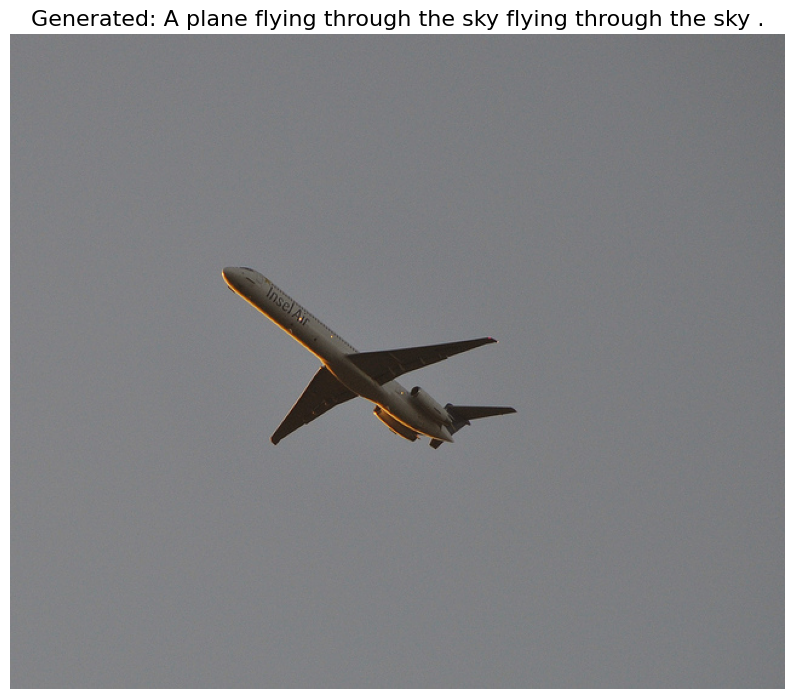

Image 2: 000000183675.jpg
Generated caption: A man riding a horse on a horse .
Ground truth captions:
  1. A man is riding a horse in an open field.
  2. Cowboy riding a horse in a huge pasture..

  3. a man riding a horse in the middle of the mountain range.



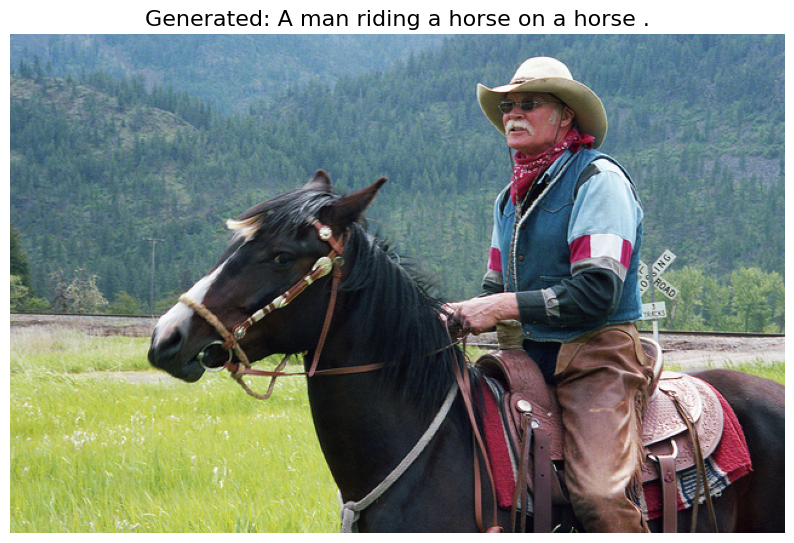

Image 3: 000000343218.jpg
Generated caption: A man holding a tennis racket on a tennis court .
Ground truth captions:
  1. a man with a tennis racket gets ready to swing his racket 
  2. A person on a court with a tennis racket.
  3. A man holding a tennis racquet on a court.



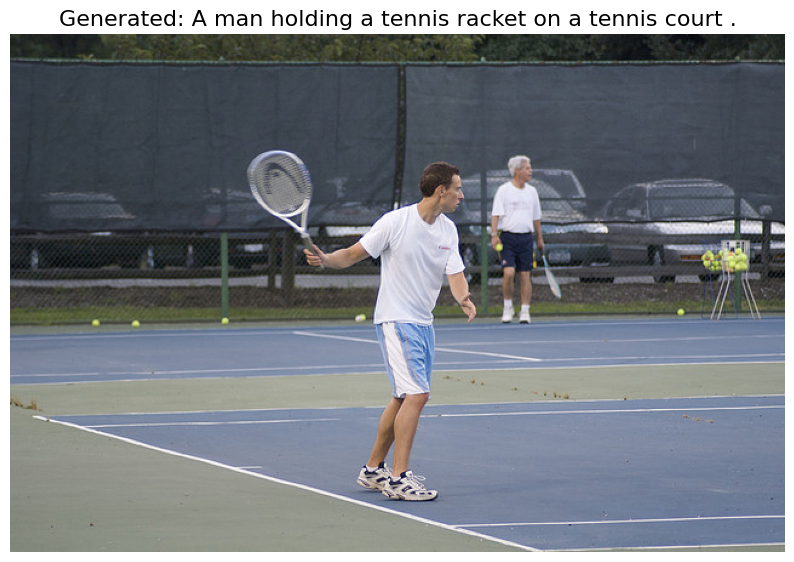

Image 4: 000000090891.jpg
Generated caption: A group of people standing next to a group of a group of people .
Ground truth captions:
  1. Five men are selling a large amount of bananas.
  2. A picture of a group of people surrounded by bananas.
  3. A group of men surrounded by clusters of bananas



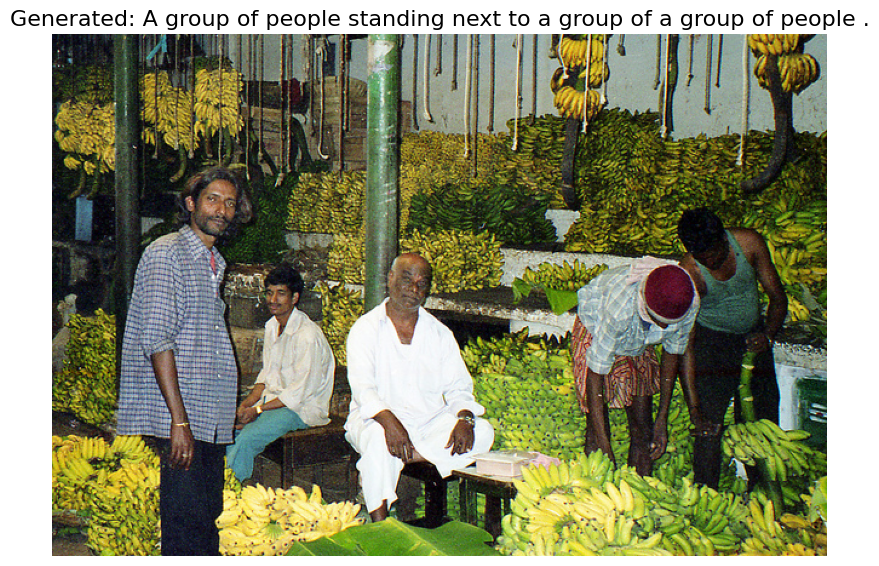

Image 5: 000000380711.jpg
Generated caption: A surfer is walking on the beach with a surfboard .
Ground truth captions:
  1. There is a blurry photo of a surfer walking out of the water
  2. Blurry photograph of a surfer emerging from the ocean with his board
  3. On a gray day a surfer carrying a white board walks on a beach.



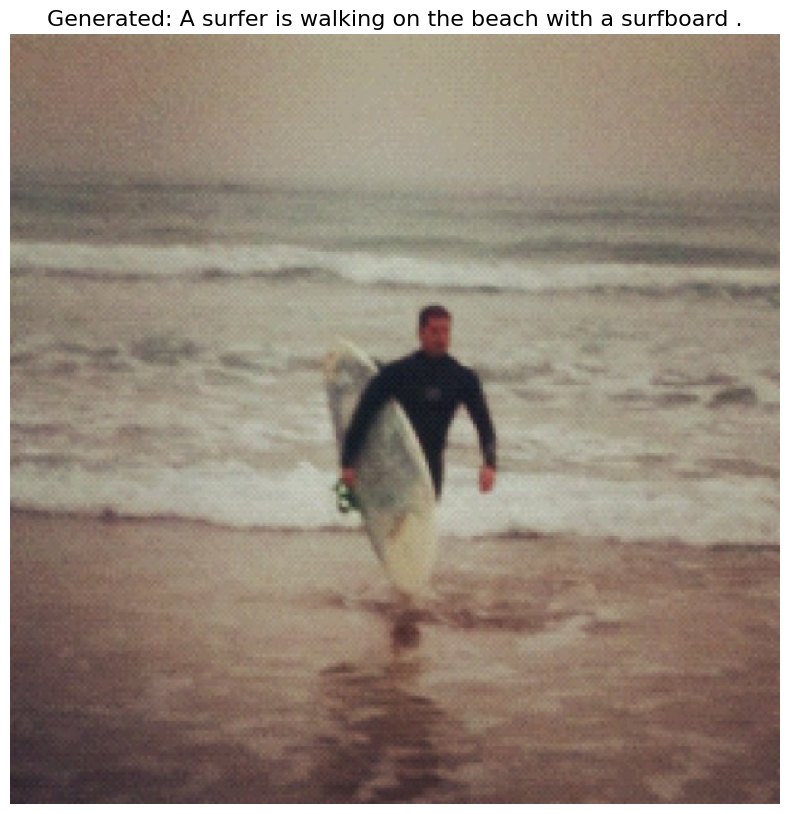

'Testing on unseen COCO images completed!'

In [ ]:
test_on_unseen_coco_images()

In [ ]:
def test_transformer_captioning_model():
    """Test the trained Transformer model on unseen images"""
    # Load vocabulary
    with open(f'{PROJECT_DIR}/data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)

    # Initialize model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = TransformerCaptioner(
      embed_size=512,
      hidden_size=2048,
      vocab_size=len(vocab),
      num_layers=4,
      max_length=max_length
    ).to(device)
    # Load best model
    best_model_path = f'{PROJECT_DIR}/models/best_model.pth'
    if os.path.exists(best_model_path):
        print("Loading best model...")
        checkpoint = safe_load_checkpoint(best_model_path, device)
        if checkpoint is not None:
            model.load_state_dict(checkpoint['model'])
            print("Model loaded successfully!")

    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Function to generate caption
    def caption_image(image_path):
        # Load and preprocess image
        if isinstance(image_path, str):
            image = Image.open(image_path).convert('RGB')
        else:
            image = image_path  # Already a PIL Image

        image_tensor = transform(image).unsqueeze(0).to(device)

        # Generate caption
        model.eval()
        with torch.no_grad():
            sampled_ids = model.sample(image_tensor)
            sampled_ids = sampled_ids[0].cpu().numpy()

        # Convert word IDs to words
        sampled_caption = []
        for word_id in sampled_ids:
            word = vocab.idx2word[word_id]
            if word == '<end>':
                break
            if word not in ['<start>', '<pad>']:
                sampled_caption.append(word)

        # Join words to form sentence
        sentence = ' '.join(sampled_caption)
        sentence = sentence.capitalize()
        if not sentence.endswith('.'):
            sentence += '.'

        return sentence

    # Test on internet images
    image_urls = [
        "https://images.pexels.com/photos/1108099/pexels-photo-1108099.jpeg",  # dog
        "https://images.pexels.com/photos/1170986/pexels-photo-1170986.jpeg",  # people on beach
        "https://images.pexels.com/photos/1154638/pexels-photo-1154638.jpeg",  # bicycle
        "https://images.pexels.com/photos/1640777/pexels-photo-1640777.jpeg",  # pizza
        "https://images.pexels.com/photos/2607544/pexels-photo-2607544.jpeg",  # downtown city
    ]

    for i, url in enumerate(image_urls):
        try:
            # Download image
            response = requests.get(url)
            image = Image.open(BytesIO(response.content)).convert('RGB')

            # Generate caption
            caption = caption_image(image)

            # Display results
            print(f"Image {i+1}:")
            print(f"Caption: {caption}\n")

            # Visualize
            plt.figure(figsize=(8, 8))
            plt.imshow(image)
            plt.title(f'Caption: {caption}', fontsize=16)
            plt.axis('off')
            plt.show()

        except Exception as e:
            print(f"Error processing image {i+1}: {e}")

    return "Testing completed!"



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Loading best model...
Model loaded successfully!
Image 1:
Caption: Two white dog sitting on a grassy field .



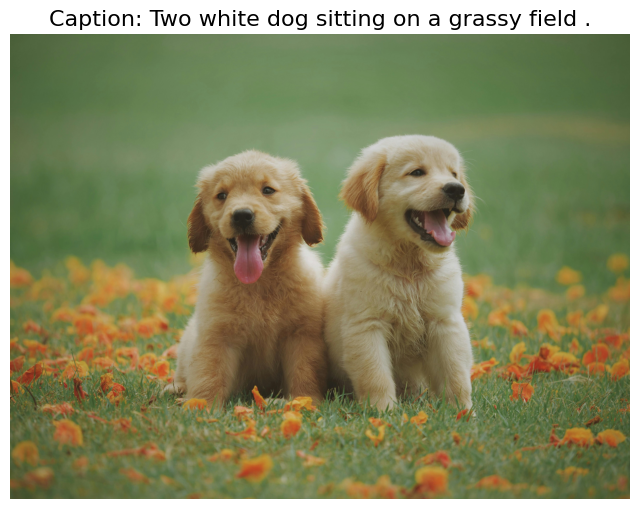

Image 2:
Caption: A cat sitting on top of a wooden cat .



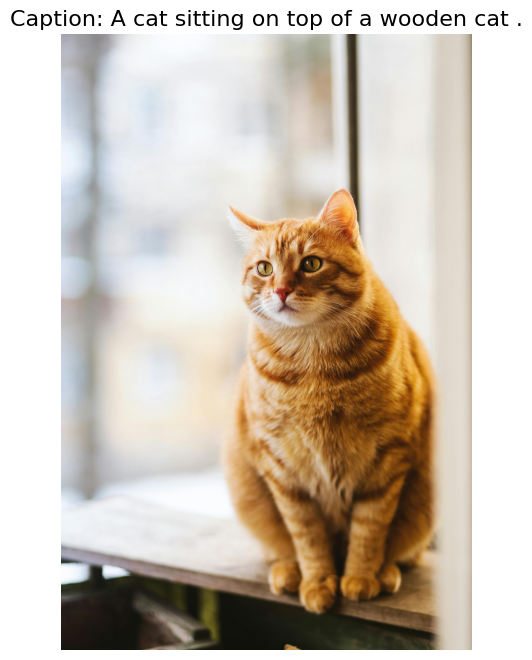

Image 3:
Caption: A woman sitting on a chair with a chair .



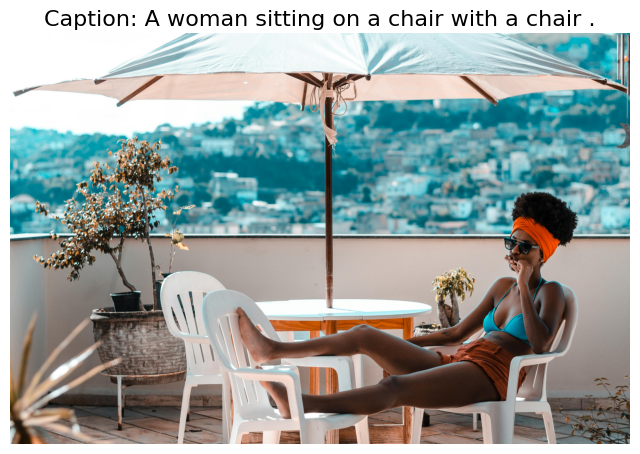

Image 4:
Caption: A bunch of food that are sitting on a table .



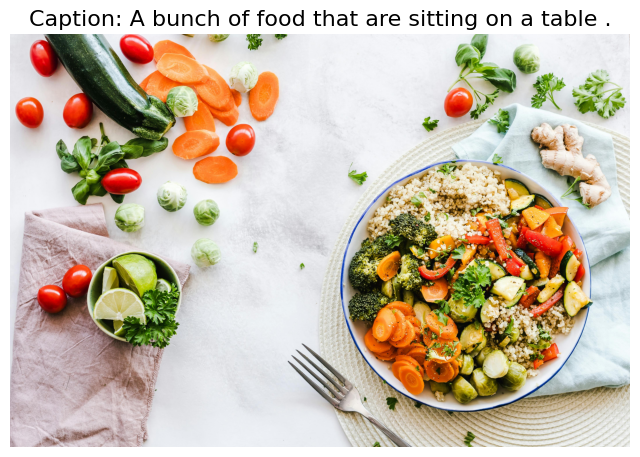

Image 5:
Caption: A white dog is laying on a beach .



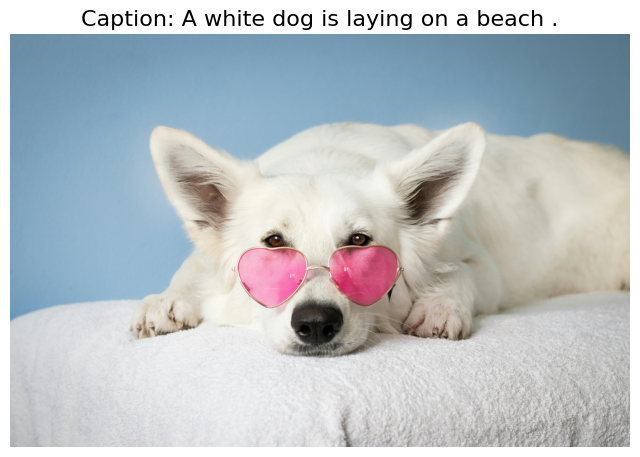

'Testing completed!'

In [ ]:
# Add this function call at the end of main() to test after training
test_transformer_captioning_model()